In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import accuracy_score
from indoNLP.preprocessing import pipeline, replace_word_elongation, replace_slang, remove_stopwords, emoji_to_words
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
import tensorflow as tf
from nltk.tokenize import word_tokenize
from gensim.models import FastText
import fasttext
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
data = pd.read_csv("./Dataset Babak Penyisihan.csv")

data = data.dropna(subset='tweet')
data_train = data[:4151]
data_test = data[4151:5154] 

# Membaca file kamus_singkatan.csv tanpa header
kamus_singkatan = pd.read_csv('kamus_singkatan.csv', header=None, sep=';')

# Mengonversi file CSV ke dalam kamus Python
kamus = {}
for index, row in kamus_singkatan.iterrows():
    singkatan = row[0]
    kata_lengkap = row[1]
    kamus[singkatan] = kata_lengkap

In [3]:
data_train = data_train.drop_duplicates(subset=['tweet'])

# Setelah menghapus data duplikat, Anda mungkin ingin mengatur ulang indeks DataFrame
data_train = data_train.reset_index(drop=True)

In [4]:
# Fungsi untuk mengganti singkatan dengan kata lengkap
def ganti_singkatan(teks):
    kata_kunci = teks.split()
    teks_baru = [kamus.get(kata, kata) for kata in kata_kunci]
    return ' '.join(teks_baru)

# Fungsi untuk membersihkan teks
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation,
    remove words containing numbers.'''
    text = re.sub(r'\[USERNAME\]|\[URL\]|\[SENSITIVE-NO\]', '', text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[^a-zA-Z]",' ',text) 
    return text

# Fungsi untuk menghapus stop words menggunakan NLTK
def remove_stopwords_nltk(text):
    text = ' '.join(word for word in text.split() if word not in stopwords.words('indonesian'))
    return text

# Tokenisasi teks
def tokenize_text(text):
    return word_tokenize(text)

def indonlp(text):
    pipe = pipeline([replace_word_elongation, replace_slang, remove_stopwords, emoji_to_words])
    return pipe(text)
    
# Pra-pemrosesan data pelatihan menggunakan NLTK dan Sastrawi
data_train['tweet'] = data_train['tweet'].apply(ganti_singkatan)
data_train['tweet'] = data_train['tweet'].apply(indonlp)
data_train['tweet'] = data_train['tweet'].apply(clean_text)
data_train['tweet'] = data_train['tweet'].apply(remove_stopwords_nltk)

In [6]:
from gensim.models import FastText
max_words = 15000
max_len = 48

def tokenize_text(text):
    '''
    This function tokenize the input text into sequences of integers
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

X, tokenizer = tokenize_text(data_train['tweet'])

In [7]:
from gensim.models import FastText
import fasttext

import numpy as np

# Path ke file model FastText dan Word2Vec
fasttext_path = "./Fastext_model_tweet.bin"

# Muat model FastText
fasttext_model = FastText.load_fasttext_format(fasttext_path)

# Dimensi vektor untuk kedua model
fasttext_dim = 100

# Jumlah kata dari tokenizer
num_words = len(tokenizer.word_index) + 1

# Inisialisasi matriks embedding hanya untuk FastText
embedding_matrix_fasttext = np.zeros((num_words, fasttext_dim))
for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix_fasttext[i] = fasttext_model.wv[word]
# Sekarang, Anda memiliki matriks embedding yang lebih terbatas dengan jumlah kata yang telah ditentukan.

C:\Users\USER\AppData\Local\Temp\ipykernel_8368\2801624795.py:10: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = FastText.load_fasttext_format(fasttext_path)


In [17]:
y = data_train['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [18]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Menghitung jumlah sampel per kelas sebelum oversampling
print("Jumlah sampel per kelas sebelum oversampling:", Counter(y_train))

# Menggunakan RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Menghitung jumlah sampel per kelas setelah oversampling
print("Jumlah sampel per kelas setelah oversampling:", Counter(y_train_resampled))


Jumlah sampel per kelas sebelum oversampling: Counter({'sadness': 918, 'joy': 840, 'anger': 708, 'fear': 565, 'love': 413})
Jumlah sampel per kelas setelah oversampling: Counter({'sadness': 918, 'love': 918, 'anger': 918, 'fear': 918, 'joy': 918})


In [19]:
y_train_resampled = pd.get_dummies(y_train_resampled)
y_test = pd.get_dummies(y_test)

In [20]:
from tensorflow.keras.layers import Embedding, GRU, Dense, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

embedding_dim = 100
max_words = 15000
max_length = 48
learning_rate = 0.1
# decay_rate = learning_rate / epochs
momentum = 0.8

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix_fasttext], input_length=max_length, trainable=False))
model.add(Bidirectional(GRU(units=64, return_sequences=True, recurrent_dropout=0.3)))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(8, activation="relu"))
model.add(Dense(5, activation='softmax'))

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    'model_gru.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=5,                        
    min_lr=0.001
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,  
    restore_best_weights=True  
)

# Pelatihan model
history = model.fit(
    X_train_resampled, 
    y_train_resampled,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.2131
Epoch 1: val_loss improved from inf to 0.51948, saving model to model_gru.h5
72/72 [==============================] - 13s 106ms/step - loss: 0.5697 - accuracy: 0.2131 - val_loss: 0.5195 - val_accuracy: 0.1859 - lr: 0.0010
Epoch 2/50


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.3566
Epoch 2: val_loss improved from 0.51948 to 0.45711, saving model to model_gru.h5
72/72 [==============================] - 8s 107ms/step - loss: 0.4477 - accuracy: 0.3566 - val_loss: 0.4571 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.5601
Epoch 3: val_loss improved from 0.45711 to 0.40678, saving model to model_gru.h5
72/72 [==============================] - 6s 87ms/step - loss: 0.3829 - accuracy: 0.5601 - val_loss: 0.4068 - val_accuracy: 0.5921 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.6070
Epoch 4: val_loss improved from 0.40678 to 0.38331, saving model to model_gru.h5
72/72 [==============================] - 8s 108ms/step - loss: 0.3451 - accuracy: 0.6070 - val_loss: 0.3833 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - ETA

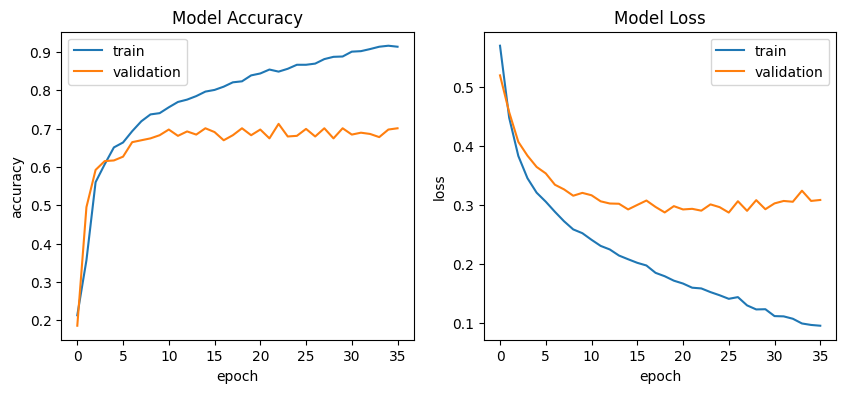

In [21]:
import matplotlib.pyplot as plt
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [23]:
model = load_model('model_gru.h5')

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Konversi hasil prediksi menjadi kelas (ambil kelas dengan nilai tertinggi)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test.to_numpy(), axis=1)  # Mengkonversi label kelas target menjadi bentuk array

# Mencetak laporan klasifikasi
print(classification_report(y_true_classes, y_pred_classes))

19/19 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       134
           1       0.84      0.72      0.77        86
           2       0.74      0.67      0.70       157
           3       0.76      0.72      0.74        75
           4       0.62      0.58      0.60       156

    accuracy                           0.70       608
   macro avg       0.72      0.71      0.71       608
weighted avg       0.71      0.70      0.70       608



In [24]:
def predict_sentiments(tweet_list):
    '''Function to predict sentiments for a list of tweets'''
    
    sentiment_classes = ['anger', 'fear', 'joy', 'love', 'sadness']
    max_len = 48
    
    # Initialize an empty list to store predicted sentiments
    predicted_sentiments = []
    
    for tweet in tweet_list:
        # Transforms tweet to a sequence of integers using the tokenizer object
        xt = tokenizer.texts_to_sequences([tweet])
        # Pad sequence to the same length
        xt = pad_sequences(xt, padding='post', maxlen=max_len)
        # Do the prediction using the loaded model
        yt = model.predict(xt).argmax(axis=1)
        # Get the predicted sentiment and add it to the list
        predicted_sentiment = sentiment_classes[yt[0]]
        predicted_sentiments.append(predicted_sentiment)
    
    return predicted_sentiments

# Ambil data tweet yang ingin diprediksi sentimennya dari data_test
tweet_list = data_test['tweet'].tolist()

# Panggil fungsi predict_sentiments
predicted_sentiments = predict_sentiments(tweet_list)

# Buat DataFrame hasil prediksi
results_df = pd.DataFrame({'label': predicted_sentiments, 'tweet': data_test['tweet'] })

# Simpan hasil prediksi ke dalam file CSV
results_df.to_csv('hasil_prediksi.csv', index=False)

1/1 [==============================] - 0s 32ms/step
